In [1]:
import math
import os
import sys
sys.path.insert(0,'../src/')
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from pandas.plotting import register_matplotlib_converters
from database import SQLiteDatabase
from experiment import preliminary_setup

In [2]:
KWARGS = preliminary_setup()
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
register_matplotlib_converters()
DB_DIRECTORY = KWARGS['database_directory']
FIGURES_DIRECTORY = KWARGS['figure_directory']
DATABASE = SQLiteDatabase(os.path.join(DB_DIRECTORY,'reward_design_1.db'))
GRID = DATABASE.get_table('grid')
SIMULATION_IDS = GRID['simulation_id'].unique()

# Cummulative reward trajectory

In [3]:
query = f"""
SELECT
    g.simulation_group,
    s.episode,
    CAST(LTRIM(s.building_name, 'Building_') AS INTEGER) AS building_id,
    MAX(g.carbon_emission_exponent) AS carbon_emission_exponent,
    MAX(g.electricity_price_exponent) AS electricity_price_exponent,
    1.0 - MAX(g.electricity_price_weight) AS carbon_emission_weight,
    MAX(g.electricity_price_weight) AS electricity_price_weight,
    AVG(s.value) AS value
FROM (
    SELECT
        s.simulation_id,
        s.episode,
        s.building_name,
        SUM(s.reward) AS value
    FROM detailed_summary s
    GROUP BY
        s.simulation_id,
        s.episode,
        s.building_name
) s
LEFT JOIN grid g ON g.simulation_id = s.simulation_id
GROUP BY
    g.simulation_group,
    s.episode,
    s.building_name
"""
reward_data = DATABASE.query_table(query)
# exclude where w_1 = 0.5 to have an even number of weight combinations
# w_1 = 5 is has similar result as w_1 = 0.4 when evaluated on average district scores.
reward_data = reward_data[reward_data['electricity_price_weight']!=0.5].copy()

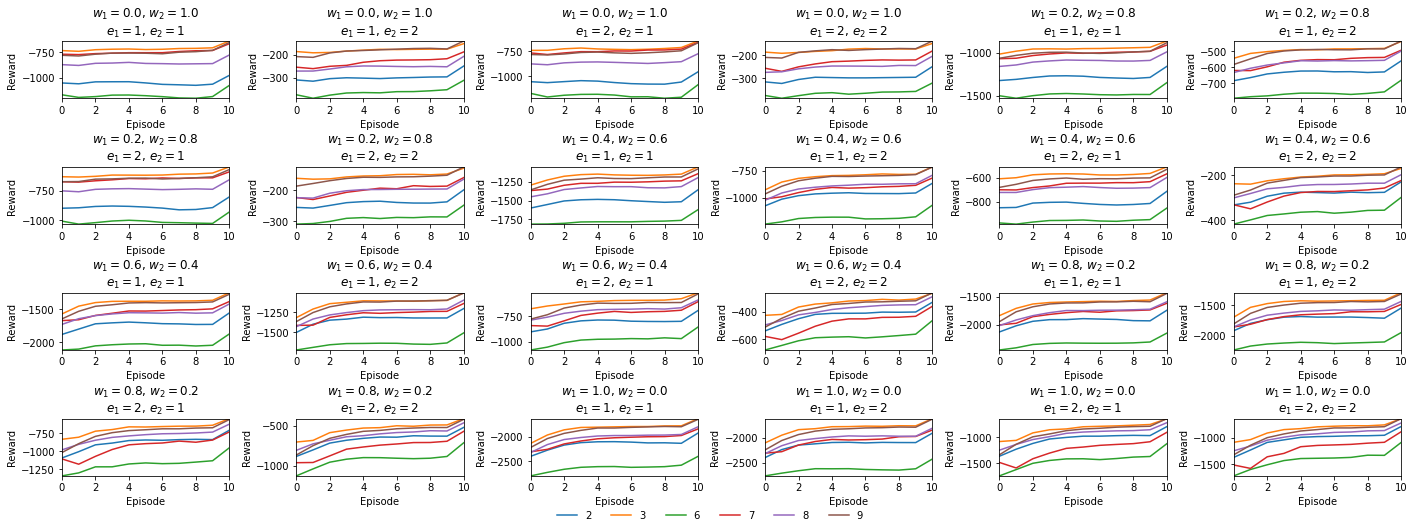

In [4]:
# reward trajectory for each buildings and reward weights-exponents combination
column_count_limit = 6
simulation_group_count = len(reward_data['simulation_group'].unique())
row_count = math.ceil(simulation_group_count/column_count_limit)
column_count = min(simulation_group_count, column_count_limit)
fig, _ = plt.subplots(row_count, column_count, figsize=(4*column_count, 2*row_count), gridspec_kw={'wspace':0.4, 'hspace':1.2})
groupby_columns = ['electricity_price_weight', 'carbon_emission_weight', 'electricity_price_exponent', 'carbon_emission_exponent',]

for i, (ax, ((p_w, c_w, p_e, c_e), s_data)) in enumerate(zip(fig.axes, reward_data.groupby(groupby_columns))):
    for b, b_data in s_data.groupby('building_id'):
        x, y = b_data['episode'], b_data['value']
        ax.plot(x, y, label=b)

    ax.set_title(r'$w_1=$' + f'{round(p_w,1)}, ' + r'$w_2=$' + f'{round(c_w,1)}\n' + r'$e_1=$' + f'{int(p_e)}, '+ r'$e_2=$' + f'{int(c_e)}')
    ax.set_xlabel('Episode')
    ax.set_ylabel('Reward')

    if i == 0:
        ax.legend(
            bbox_to_anchor=(0.5,0.08),
            loc='upper center', 
            bbox_transform=fig.transFigure,
            framealpha=0,
            ncol=6
        )
    else:
        ax.legend().set_visible(False)

plt.show()

- The agents converge after about 8 episodes of training
- Building 6 has very low reward compared to other buildings (not sure why).

# Electricity price and carbon emission costs

In [5]:
# query
query = f"""
WITH carbon_emission AS (
    SELECT
        d.simulation_id,
        d.episode,
        d.building_name,
        SUM(MAX(0, d.net_electricity_consumption_emission)) AS value,
        SUM(MAX(0, d.net_electricity_consumption_emission))/SUM(MAX(0, d.net_electricity_consumption_emission_without_storage)) AS norm_value
    FROM detailed_summary d
    GROUP BY
        d.simulation_id,
        d.episode,
        d.building_name
), price AS (
    SELECT
        d.simulation_id,
        d.episode,
        d.building_name,
        SUM(MAX(0, d.net_electricity_consumption_price)) AS value,
        SUM(MAX(0, d.net_electricity_consumption_price))/SUM(MAX(0, d.net_electricity_consumption_price_without_storage)) AS norm_value
    FROM detailed_summary d
    GROUP BY
        d.simulation_id,
        d.episode,
        d.building_name
)

SELECT
    g.simulation_group,
    g.carbon_emission_exponent,
    g.electricity_price_exponent,
    1.0 - g.electricity_price_weight AS carbon_emission_weight,
    g.electricity_price_weight,
    c.episode,
    CAST(LTRIM(c.building_name, 'Building_') AS INTEGER) AS building_id,
    AVG(c.value) AS carbon_emission,
    AVG(p.value) AS price,
    AVG(c.norm_value) AS norm_carbon_emission,
    AVG(p.norm_value) AS norm_price,
    (AVG(c.value) + AVG(p.value))/2.0 AS average_score,
    (AVG(c.norm_value) + AVG(p.norm_value))/2.0 AS average_norm_score
FROM grid g
LEFT JOIN carbon_emission c ON c.simulation_id = g.simulation_id
LEFT JOIN price p ON p.episode = c.episode AND p.building_name = c.building_name AND p.simulation_id = c.simulation_id
GROUP BY
    g.simulation_group,
    g.carbon_emission_exponent,
    g.electricity_price_exponent,
    g.electricity_price_weight,
    c.episode,
    c.building_name
"""
building_cost_data = DATABASE.query_table(query)
# exclude where w_1 = 0.5 to have an even number of weight combinations
# w_1 = 5 is has similar result as w_1 = 0.4 when evaluated on average district scores.
building_cost_data = building_cost_data[building_cost_data['electricity_price_weight']!=0.5].copy()
district_cost_data = building_cost_data.groupby([
    'simulation_group', 
    'carbon_emission_exponent', 
    'electricity_price_exponent', 
    'carbon_emission_weight', 
    'electricity_price_weight',
    'episode'
])[['carbon_emission','price','average_score','norm_carbon_emission','norm_price','average_norm_score']].mean().reset_index()

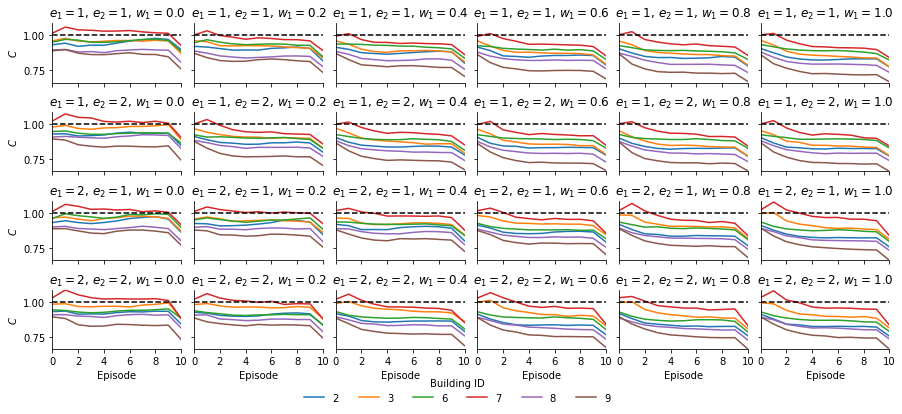

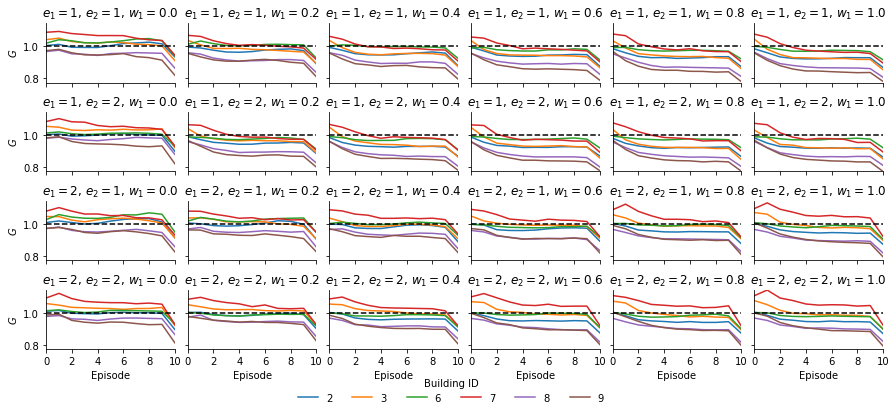

In [6]:
# electricity price and carbon emission cost per building for all episodes
column_count_limit = 6
simulation_group_count = len(reward_data['simulation_group'].unique())
row_count = math.ceil(simulation_group_count/column_count_limit)
column_count = min(simulation_group_count, column_count_limit)

groupby_columns = ['electricity_price_exponent', 'carbon_emission_exponent','electricity_price_weight', 'carbon_emission_weight', ]
value_columns = ['norm_price','norm_carbon_emission']
value_labels = [r'$C$',r'$G$']

for v, l in zip(value_columns, value_labels):
    fig, _ = plt.subplots(row_count, column_count, figsize=(2.5*column_count, 1.5*row_count), sharex=True, sharey=True, gridspec_kw={'wspace':0.1, 'hspace':0.5})
    
    for i, (ax, ((p_e, c_e, p_w, c_w,), s_data)) in enumerate(zip(fig.axes, building_cost_data.groupby(groupby_columns))):
        for b, b_data in s_data.groupby('building_id'):
            x, y = b_data['episode'], b_data[v]
            ax.plot(x, y, label=b)

        ax.set_title(r'$e_1=$' + f'{int(p_e)}, '+ r'$e_2=$' + f'{int(c_e)}, ' + r'$w_1=$' + f'{round(p_w,1)}')
        ax.axhline(1.0,color='black',linestyle='--')
        ax.xaxis.set_major_locator(MultipleLocator(2))

        for s in ['right','top']:
            ax.spines[s].set_visible(False)

        if i == 0:
            ax.legend(
                title='Building ID',
                bbox_to_anchor=(0.5,0.08),
                loc='upper center', 
                bbox_transform=fig.transFigure,
                framealpha=0,
                ncol=6
            )
        else:
            ax.legend().set_visible(False)

        if i%column_count == 0:
            ax.set_ylabel(l)
        else:
            ax.set_ylabel(None)

        if i>= row_count*column_count - column_count:
            ax.set_xlabel('Episode')
        else:
            ax.set_xlabel(None)

    plt.savefig(os.path.join(FIGURES_DIRECTORY,f'reward_design_1_building_{v.replace("norm_","")}.pdf'),bbox_inches='tight',transparent=True)
    plt.show()

- Figure above shows the aggregated electricity price and carbon emission normalized against their equivalent for no-control scenario for each building and training episode.
- Recall that the controller uses RBC for first 3671 time-steps before switching to RL algorithm.
- In all combinations of reward parameters, the RL solution is able to outperform the no control scenario but also the RBC in the first 3671 time steps.
- Lowest electricity price scores as well as carbon emission scores are achieved with higher $w_1$.
- Exponent does not seem to make much of a difference.

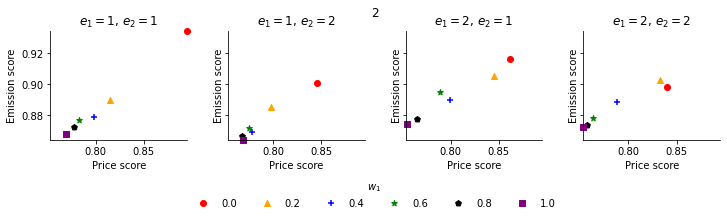

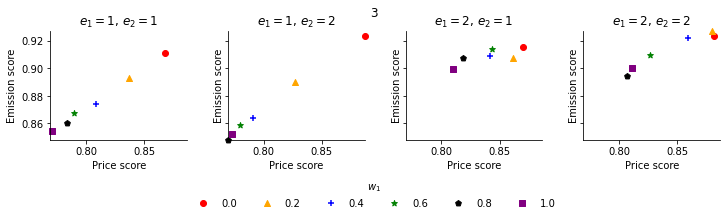

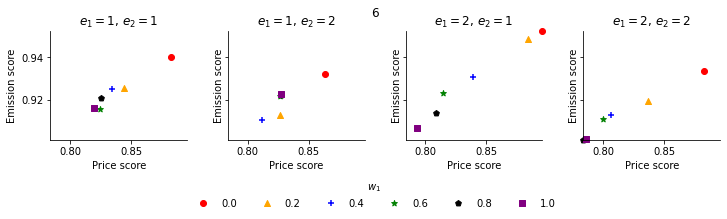

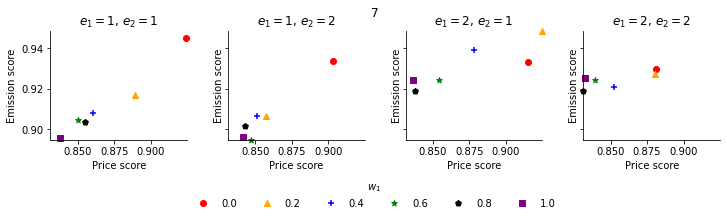

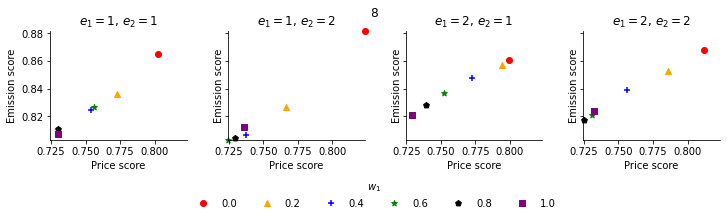

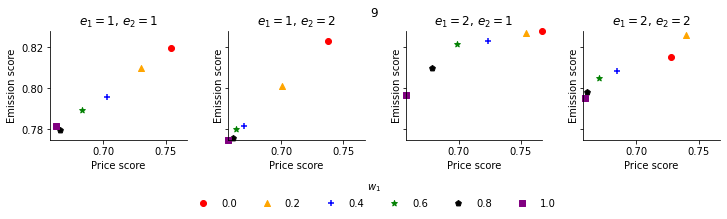

In [7]:
# price - emission scatter per building
colors = ['red','orange','blue','green','black','purple']
markers = ['o','^','+','*','p','s']

for b, b_data in building_cost_data.groupby('building_id'):
    plot_data = b_data[
        (b_data['episode']==b_data['episode'].max())
    ].copy()
    exponent_combinations = plot_data.groupby(['electricity_price_exponent', 'carbon_emission_exponent']).size().shape[0]
    column_count_limit = 4
    row_count, column_count = math.ceil(exponent_combinations/column_count_limit), min(exponent_combinations, column_count_limit)
    fig, _ = plt.subplots(row_count, column_count, figsize=(3*column_count, 2*row_count), sharex=True, sharey=True, gridspec_kw={'wspace':0.3})

    for j, (ax, ((p_e, c_e), e_data)) in enumerate(zip(fig.axes, plot_data.groupby(['electricity_price_exponent', 'carbon_emission_exponent']))):
        for i, ((p_w, c_w), w_data) in enumerate(e_data.groupby(['electricity_price_weight', 'carbon_emission_weight'])):
            x, y = w_data['norm_price'], w_data['norm_carbon_emission']
            ax.scatter(x,y,clip_on=False,color=colors[i],marker=markers[i],label=f'{round(p_w,1)}')

        for s in ['right','top']:
            ax.spines[s].set_visible(False)

        ax.set_title(r'$e_1=$' + f'{int(p_e)}, ' + r'$e_2=$' + f'{int(c_e)}')
        ax.set_xlabel('Price score')
        ax.set_ylabel('Emission score')

        if j == 0:
            ax.legend(
                title=r'$w_1$',
                bbox_to_anchor=(0.5,-0.1),
                loc='upper center', 
                bbox_transform=fig.transFigure,
                framealpha=0,
                ncol=6
            )
        else:
            ax.legend().set_visible(False)

    fig.suptitle(b,y=1.05)
    plt.show()

- The figure shows the distribution of electricity price and carbon emission costs for the last episode per building for different exponent and weight combinations.
- For each exponent combination and in all buildings, there is generally a linear relationship between price and emission scores.
- For each exponent combination and in all buildings, $w_1$ is indirectly proportional to both carbon emission and electricity price score showing that the weight on the electricity price yields better results.
- The combination of $e_1=1, e_2=1$ and $e_1=1, e_2=2$.
- There are some buildings that have preferable exponent and weights that are different from others. However, CityLearn is not robust enough to set up each building with unique parameters. Also, since there is transfer learning to be done to unseen buildings, it is best to pick parameters that perform well on an average i.e. district scale.


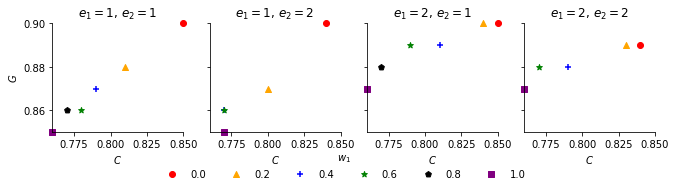

Minimum C: {'carbon_emission_exponent': 2.0, 'electricity_price_exponent': 2.0, 'electricity_price_weight': 1.0, 'norm_carbon_emission': 0.87, 'norm_price': 0.76, 'average_norm_score': 0.82}
Minimum G: {'carbon_emission_exponent': 2.0, 'electricity_price_exponent': 1.0, 'electricity_price_weight': 1.0, 'norm_carbon_emission': 0.85, 'norm_price': 0.77, 'average_norm_score': 0.81}
Minimum average: {'carbon_emission_exponent': 2.0, 'electricity_price_exponent': 1.0, 'electricity_price_weight': 1.0, 'norm_carbon_emission': 0.85, 'norm_price': 0.77, 'average_norm_score': 0.81}


In [11]:
# price - emission scatter on average (district)
plot_data = district_cost_data[
    (district_cost_data['episode']==district_cost_data['episode'].max())
].copy()
plot_data[['norm_price', 'norm_carbon_emission', 'average_norm_score']] = plot_data[['norm_price', 'norm_carbon_emission', 'average_norm_score']].round(2)
exponent_combinations = plot_data.groupby(['electricity_price_exponent', 'carbon_emission_exponent']).size().shape[0]
column_count_limit = 4
row_count, column_count = math.ceil(exponent_combinations/column_count_limit), min(exponent_combinations, column_count_limit)
fig, _ = plt.subplots(row_count, column_count, figsize=(2.7*column_count, 2*row_count), sharex=True, sharey=True, gridspec_kw={'wspace':0.2, 'hspace':0.3})
colors = ['red','orange','blue','green','black','purple']
markers = ['o','^','+','*','p','s']

for j, (ax, ((p_e, c_e), e_data)) in enumerate(zip(fig.axes, plot_data.groupby(['electricity_price_exponent', 'carbon_emission_exponent']))):
    for i, ((p_w, c_w), w_data) in enumerate(e_data.groupby(['electricity_price_weight', 'carbon_emission_weight'])):
        x, y = w_data['norm_price'], w_data['norm_carbon_emission']
        ax.scatter(x,y,clip_on=False,color=colors[i],marker=markers[i],label=f'{round(p_w,1)}')

    for s in ['right','top']:
        ax.spines[s].set_visible(False)

    ax.set_title(r'$e_1=$' + f'{int(p_e)}, ' + r'$e_2=$' + f'{int(c_e)}')
    ax.tick_params('x',which='both',rotation=0)
    

    if j == 0:
        ax.legend(
            title=r'$w_1$',
            bbox_to_anchor=(0.5,0.05),
            loc='upper center', 
            bbox_transform=fig.transFigure,
            framealpha=0,
            ncol=6
        )
    else:
        ax.legend().set_visible(False)

    if j%column_count == 0:
        ax.set_ylabel(r'$G$')
    else:
        ax.set_ylabel(None)

    if j>= row_count*column_count - column_count:
        ax.set_xlabel(r'$C$')
    else:
        ax.set_xlabel(None)

plt.savefig(os.path.join(FIGURES_DIRECTORY,f'reward_design_1_last_episode_district_price_and_emission_scores.pdf'),bbox_inches='tight',transparent=True)
plt.show()
summary = plot_data[['carbon_emission_exponent','electricity_price_exponent','electricity_price_weight','norm_carbon_emission','norm_price','average_norm_score']].copy()
print('Minimum C:',summary.sort_values('norm_price').iloc[0].to_dict())
print('Minimum G:',summary.sort_values('norm_carbon_emission').iloc[0].to_dict())
print('Minimum average:',summary.sort_values('average_norm_score').iloc[0].to_dict())
display()